In [1]:
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

import requests

import PIL
from PIL import Image

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = transforms.Compose([transforms.Resize((28,28)),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

In [46]:
def img_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

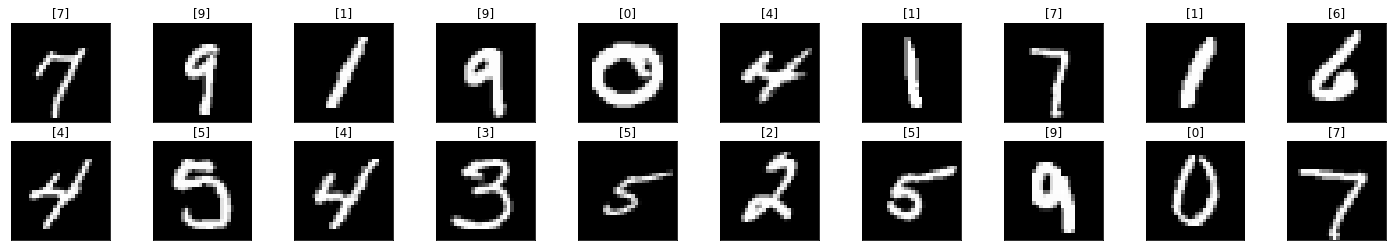

In [5]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(img_convert(images[idx]))
    ax.set_title([labels[idx].item()])

In [48]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [49]:
def calculate_corrects_and_losses(loader, model, loss_function):
    loss = 0.0
    correct = 0.0
    
    running_loss = 0.0
    running_correct = 0.0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            res = loss_function(outputs, labels)
            running_loss += res.item()

            _, pred_labels = torch.max(outputs, 1)
            running_correct += torch.sum(pred_labels == labels.data)
        
    loss = running_loss / len(loader)
    correct = running_correct.float() / len(loader)
        
    return loss, correct

In [50]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [52]:
epochs = 15
losses = []
corrects = []

val_losses = []
val_corrects = []

for e in range(epochs):
    running_loss = 0.0
    running_correct = 0.0
    
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, pred_labels = torch.max(outputs, 1)
        running_correct += torch.sum(pred_labels == labels.data)
        
    epoch_loss = running_loss / len(training_loader)
    losses.append(epoch_loss)
    
    epoch_correct = running_correct.float() / len(training_loader)
    corrects.append(epoch_correct)
    
    print('training loss: {:.4f} corrects: {:.4f}'.format(epoch_loss, epoch_correct))
    
    val_epoch_loss, val_epoch_correct = calculate_corrects_and_losses(validation_loader, model, criterion)
    val_losses.append(val_epoch_loss)
    val_corrects.append(val_epoch_correct)

training loss: 0.1880 corrects: 94.3233
training loss: 0.0541 corrects: 98.3683
training loss: 0.0392 corrects: 98.8167
training loss: 0.0310 corrects: 99.0050
training loss: 0.0262 corrects: 99.1817
training loss: 0.0217 corrects: 99.3167
training loss: 0.0194 corrects: 99.3750
training loss: 0.0181 corrects: 99.4300
training loss: 0.0163 corrects: 99.4533
training loss: 0.0140 corrects: 99.5583
training loss: 0.0130 corrects: 99.5883
training loss: 0.0121 corrects: 99.5783
training loss: 0.0121 corrects: 99.6050
training loss: 0.0093 corrects: 99.7000
training loss: 0.0096 corrects: 99.7067


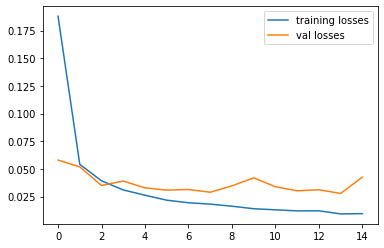

In [53]:
plt.plot(losses, label='training losses')
plt.plot(val_losses, label='val losses')
plt.legend()

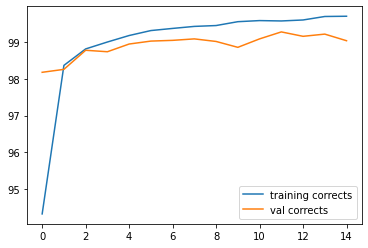

In [54]:
plt.plot([x.cpu() for x in corrects], label='training corrects')
plt.plot([x.cpu() for x in val_corrects], label='val corrects')
plt.legend()

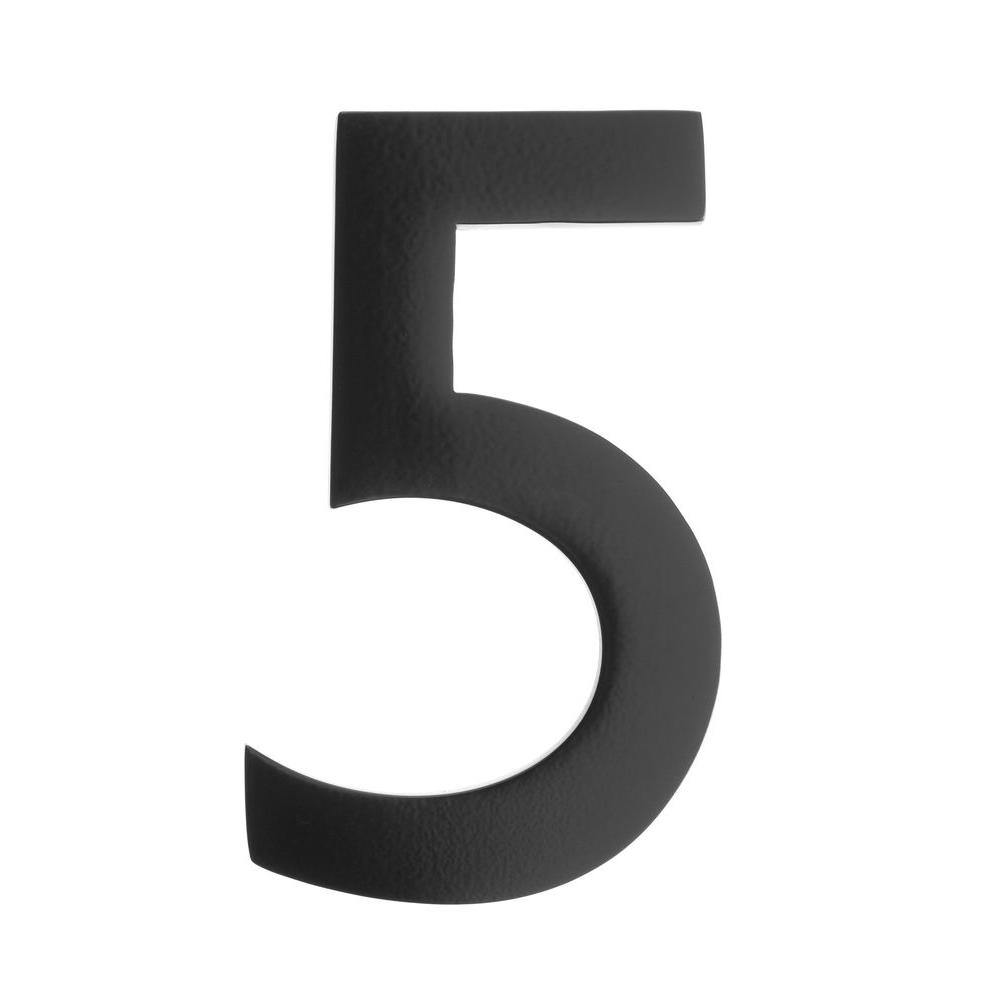

In [37]:
url = "https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg"
response = requests.get(url, stream=True)
img = Image.open(response.raw)
img

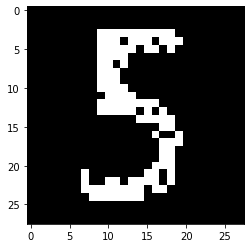

In [38]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img)
plt.imshow(img_convert(img))

In [43]:
img = img.to(device)
img = img.unsqueeze(0)
img.size()

torch.Size([1, 1, 28, 28])

In [44]:
output = model(img)
_, pred_label = torch.max(output, 1)
pred_label

tensor([5], device='cuda:0')

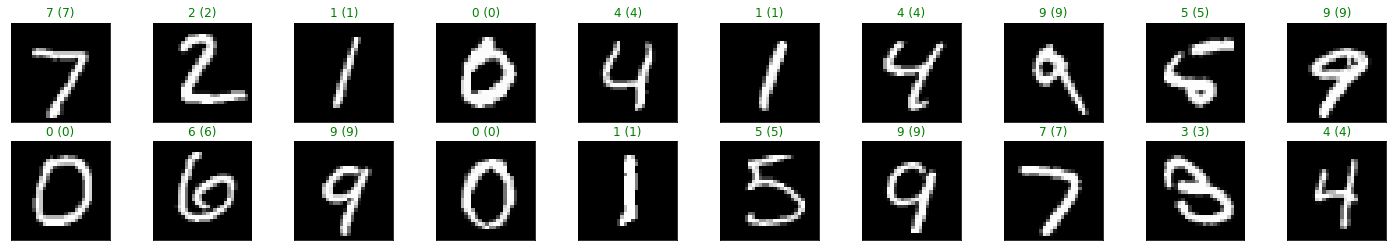

In [47]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
fig = plt.figure(figsize=(25, 4))

outputs = model(images)
_, pred_labels = torch.max(outputs, 1)

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(img_convert(images[idx]))
    ax.set_title("{} ({})".format(pred_labels[idx], labels[idx]), color=("green" if pred_labels[idx] == labels[idx] else "red"))